## k-means and labels

In [1]:
import graphlab as gl
import networkx as nx
from matplotlib.pyplot import *
gl.canvas.set_target('ipynb')
%matplotlib inline

2016-04-04 19:50:31,523 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1459792230.log


This trial license of GraphLab Create is assigned to juliusnagel.n@gmail.com and will expire on April 16, 2016. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.


In [2]:
path_to_dir = "../data_and_model/"

Load existing SFrame with extracted features attached:

In [3]:
image_sf = gl.load_sframe(path_to_dir + "image_sf_COS_pics")
image_sf.print_rows(5)

+-------------------------+-------------------------------+----+
|          image          |            features           | id |
+-------------------------+-------------------------------+----+
| Height: 1080 Width: 720 | [0.0, 0.0, 0.0, 0.0, 0.0, ... | 0  |
| Height: 1080 Width: 720 | [0.0, 0.0, 0.0, 0.0, 1.483... | 1  |
|  Height: 525 Width: 350 | [0.0, 0.0, 0.0, 0.0, 2.007... | 2  |
| Height: 1080 Width: 720 | [0.0, 0.0, 0.0, 0.68589973... | 3  |
|  Height: 525 Width: 350 | [0.0, 0.0, 0.0, 0.49331176... | 4  |
+-------------------------+-------------------------------+----+
[1554 rows x 3 columns]



View pictures in notebook:

In [4]:
image_sf['image'][9:12].show()

## Create nearest neighbor model to construct graph

In [5]:
model = gl.nearest_neighbors.create(image_sf,  label='id', features=['features'], distance='cosine')


Starting brute force nearest neighbors model training.

In [8]:
model.query(image_sf[image_sf['id'] == 71])

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0643501   | 43.392ms     |

| Done         |         | 100         | 288.15ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,71,0.0,1
0,505,0.0145490530296,2
0,1217,0.0145490530296,3
0,675,0.0970624159921,4
0,252,0.156395219206,5


In [9]:
image_sf.filter_by([71, 505, 1217, 675, 252] , 'id')['image'].show()


In [10]:
sg = model.similarity_graph(k=None, radius=.2, include_self_edges=False, output_type='SFrame', verbose=True)


Starting blockwise similarity graph construction.

max rows per data block: 7668

number of reference data blocks: 4

+---------+-------------+--------------+

| # Pairs | % Complete. | Elapsed Time |

+---------+-------------+--------------+

| 452020  | 29.8716     | 670.045ms    |

| 1206681 | 79.7431     | 1.69s        |

| 1513210 | 100         | 2.15s        |

+---------+-------------+--------------+

In [15]:
gg = gl.SGraph()
gg = gg.add_vertices(image_sf, vid_field="id")
gg = gg.add_edges(sg, src_field='query_label', dst_field='reference_label')

In [19]:
gg.vertices

__id,image,features
350,Height: 1080 Width: 720,"[0.0, 0.0, 0.0,0.216604828835, 0.0, ..."
268,Height: 1080 Width: 720,"[0.0, 0.0, 0.27183920145,1.24535918236, ..."
238,Height: 1080 Width: 720,"[0.0, 0.0, 2.40972614288,0.0, 0.295669436455, ..."
175,Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
136,Height: 525 Width: 350,"[0.0, 0.0, 0.0,0.228527605534, ..."
113,Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0,0.158575534821, 0.0, ..."
110,Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
96,Height: 525 Width: 350,"[0.0, 0.0, 0.0,0.265191316605, 0.0, ..."
52,Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0, 0.0,1.92297530174, 0.0, ..."
50,Height: 525 Width: 350,"[0.0, 0.0, 0.0,2.53102970123, ..."


## Visualize the network:

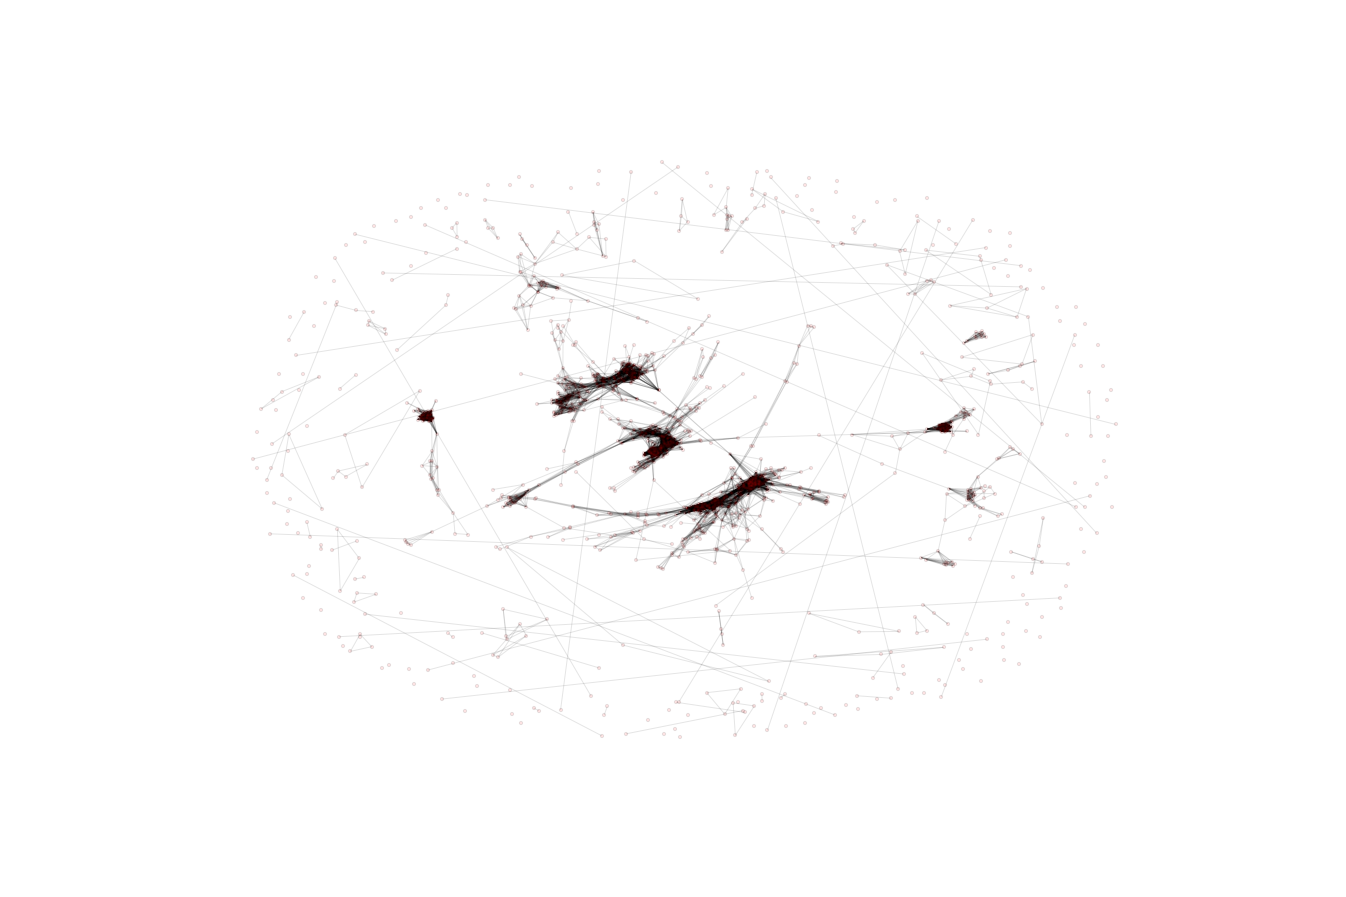

In [20]:
%matplotlib inline
G = nx.Graph()
G.add_nodes_from(list(gg.vertices["__id"]))
G.add_weighted_edges_from([(k['__src_id'], k['__dst_id'], k['distance']) for k in list(gg.edges)])
figure(figsize=(18,12))
pos = nx.spring_layout(G)
nx.draw(G,pos, alpha=.1, node_size=10)

In [21]:
model_kmeans = gl.kmeans.create(image_sf, features=['features'], num_clusters=6)


Batch size is larger than the input dataset. Switching to an exact Kmeans method.

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 1193      |

| 1             | 391       |

| 2             | 659       |

| 3             | 791       |

| 4             | 1514      |

| 5             | 740       |

+---------------+-----------+

Starting kmeans model training.

Assigning points to initial cluster centers.

+-----------+-------------------------------+

| Iteration | Number of changed assignments |

+-----------+-------------------------------+

| 1         | 189                           |

| 2         | 66                            |

| 3         | 10                            |

| 4         | 9                             |

| 5         | 4                             |

| 6         | 0                             |

+-----------+-------------------------------+

In [22]:
model_kmeans['cluster_info'].print_rows(10)


+-------------------------------+------------+------+----------------------+
|            features           | cluster_id | size | sum_squared_distance |
+-------------------------------+------------+------+----------------------+
| [0.0, 0.0400644371759, 0.0... |     0      |  67  |    59644.7944794     |
| [0.000260615807313, 0.0632... |     1      | 780  |    1496559.85321     |
| [0.0, 0.0343771731412, 0.0... |     2      | 243  |    387349.226013     |
| [0.00272833907997, 0.11556... |     3      | 273  |    673232.530701     |
| [0.0225521315516, 0.153793... |     4      | 113  |    224961.822693     |
| [0.0, 0.0189819886134, 0.0... |     5      |  78  |    115117.367615     |
+-------------------------------+------------+------+----------------------+
[6 rows x 4 columns]



In [28]:
image_sf.rename({"id": "__id"})

image,features,__id
Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0, 0.0,0.19113701582, 0.0, 0.0, ...",0
Height: 1080 Width: 720,"[0.0, 0.0, 0.0, 0.0,1.48380994797, ...",1
Height: 525 Width: 350,"[0.0, 0.0, 0.0, 0.0,2.0076174736, 0.0, 0.0, ...",2
Height: 1080 Width: 720,"[0.0, 0.0, 0.0,0.685899734497, 0.0, ...",3
Height: 525 Width: 350,"[0.0, 0.0, 0.0,0.49331176281, ...",4
Height: 1080 Width: 720,"[0.0, 0.0, 0.0,0.379939436913, 0.0, ...",5
Height: 1080 Width: 720,"[0.0, 0.0, 1.21128451824,0.0, 4.27542972565, 0.0, ...",6
Height: 1080 Width: 720,"[0.0, 0.0, 0.0,1.8547590971, ...",7
Height: 525 Width: 350,"[0.0, 0.0, 0.0, 0.0,1.17143547535, ...",8
Height: 525 Width: 350,"[0.0, 0.0, 0.0, 0.0,2.47317957878, ...",9


In [29]:

images = image_sf.add_row_number()

def show_topk_pagerank(kmeans_model, graph, cluster_id, show_plot=True):
    # find all image ids in a given cluster
    ids = kmeans_model['cluster_id'].filter_by(cluster_id, 'cluster_id')['row_id']
    # initiate an SGraph
    subgraph = gl.SGraph()
    # add images to graph from the id's filtered above
    subgraph = subgraph.add_vertices(images.filter_by(ids, 'id'))
    # add edges that exist ONLY within the cluster
    subedges = graph.edges.filter_by(subgraph.vertices['__id'], '__src_id')
    subedges = subedges.filter_by(subgraph.vertices['__id'], '__dst_id')
    subgraph = subgraph.add_edges(subedges)
    # compute pagerank on subgraph
    pr = gl.pagerank.create(subgraph)
    # sort and show
    pr = pr['graph'].vertices.sort('pagerank', False)
    if show_plot:
        images.filter_by(pr[:9]['__id'], '__id')['image'].show()
    return pr[:9]['__id']

In [30]:
ids_0 = show_topk_pagerank(model_kmeans, gg, 0)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 12.5412               |

| 2         | 4.16936               |

| 3         | 2.3588                |

| 4         | 1.45404               |

| 5         | 1.08481               |

| 6         | 0.72088               |

| 7         | 0.519236              |

| 8         | 0.357819              |

| 9         | 0.254226              |

| 10        | 0.177928              |

| 11        | 0.125762              |

| 12        | 0.0886441             |

| 13        | 0.0628644             |

| 14        | 0.0443755             |

| 15        | 0.0315173             |

| 16        | 0.0222803             |

| 17        | 0.0158395             |

| 18        | 0.0112171             |

| 19        | 0.00797792            |

+-----------+-----------------------+

In [31]:
ids_1 = show_topk_pagerank(model_kmeans, gg, 1)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 247.784               |

| 2         | 67.567                |

| 3         | 28.1957               |

| 4         | 17.7407               |

| 5         | 12.2487               |

| 6         | 8.7404                |

| 7         | 6.4665                |

| 8         | 4.77535               |

| 9         | 3.62973               |

| 10        | 2.74408               |

| 11        | 2.12516               |

| 12        | 1.64021               |

| 13        | 1.28748               |

| 14        | 1.01042               |

| 15        | 0.803687              |

| 16        | 0.64041               |

| 17        | 0.515036              |

| 18        | 0.413766              |

| 19        | 0.334551              |

| 20        | 0.270513              |

+-----------+-----------------------+

In [32]:
ids_2 = show_topk_pagerank(model_kmeans, gg, 2)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 71.8882               |

| 2         | 21.2218               |

| 3         | 8.84786               |

| 4         | 4.65468               |

| 5         | 2.94177               |

| 6         | 2.01888               |

| 7         | 1.48606               |

| 8         | 1.12513               |

| 9         | 0.856483              |

| 10        | 0.652466              |

| 11        | 0.497824              |

| 12        | 0.37992               |

| 13        | 0.289732              |

| 14        | 0.220818              |

| 15        | 0.16821               |

| 16        | 0.12811               |

| 17        | 0.0975576             |

| 18        | 0.0743138             |

| 19        | 0.0566045             |

| 20        | 0.0431136             |

+-----------+-----------------------+

In [33]:
ids_3 = show_topk_pagerank(model_kmeans, gg, 3)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 77.8744               |

| 2         | 5.98059               |

| 3         | 2.80454               |

| 4         | 1.87721               |

| 5         | 1.40163               |

| 6         | 1.06263               |

| 7         | 0.859781              |

| 8         | 0.682242              |

| 9         | 0.566232              |

| 10        | 0.462714              |

| 11        | 0.387614              |

| 12        | 0.322051              |

| 13        | 0.271026              |

| 14        | 0.227319              |

| 15        | 0.191779              |

| 16        | 0.161731              |

| 17        | 0.136644              |

| 18        | 0.115597              |

| 19        | 0.0977654             |

| 20        | 0.0828515             |

+-----------+-----------------------+

In [34]:
ids_4 = show_topk_pagerank(model_kmeans, gg, 4)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 28.5781               |

| 2         | 6.24265               |

| 3         | 2.40308               |

| 4         | 1.35134               |

| 5         | 0.833248              |

| 6         | 0.534831              |

| 7         | 0.375296              |

| 8         | 0.249124              |

| 9         | 0.180139              |

| 10        | 0.125001              |

| 11        | 0.0916873             |

| 12        | 0.0664517             |

| 13        | 0.0496269             |

| 14        | 0.0375522             |

| 15        | 0.0284508             |

| 16        | 0.0221177             |

| 17        | 0.0170201             |

| 18        | 0.0133489             |

| 19        | 0.0104088             |

| 20        | 0.00820343            |

+-----------+-----------------------+

In [35]:
ids_5 = show_topk_pagerank(model_kmeans, gg, 5)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 16.2044               |

| 2         | 4.21252               |

| 3         | 1.29879               |

| 4         | 0.581246              |

| 5         | 0.337546              |

| 6         | 0.251643              |

| 7         | 0.20438               |

| 8         | 0.170224              |

| 9         | 0.141311              |

| 10        | 0.117069              |

| 11        | 0.0967296             |

| 12        | 0.0797755             |

| 13        | 0.0656815             |

| 14        | 0.0540075             |

| 15        | 0.0443605             |

| 16        | 0.0364058             |

| 17        | 0.029857              |

| 18        | 0.0244729             |

| 19        | 0.020051              |

| 20        | 0.0164222             |

+-----------+-----------------------+

In [36]:
dict_labels= { 4: 'socks_and_shoes',
               2: 'darker_shirts', 
               0: 'pants_single', 
               1: 'full_body_darker_colours', 
               5: 'dark_pants_white_shirt',
               3: 'brighter_shirts'}

def assign_labels_to_nodes(dict_labels, kmeans_model):
    for cluster_id in range(10):
        ids = kmeans_model['cluster_id'].filter_by(cluster_id, 'cluster_id')['row_id']
        cluster_images = images.filter_by(ids, 'id')
        graph_ids = list(cluster_images['__id'])
        
        for node in graph_ids:
            G.node[node]['category'] = dict_labels[cluster_id]

In [37]:
assign_labels_to_nodes(dict_labels, model_kmeans)

color_map = {'socks_and_shoes': '#4c36d9',
             'darker_shirts': '#f20000',
             'pants_single': '#ffd580',
             'full_body_darker_colours': '#a63a29',
             'dark_pants_white_shirt': '#000f73',
             'brighter_shirts': '#00735c'}

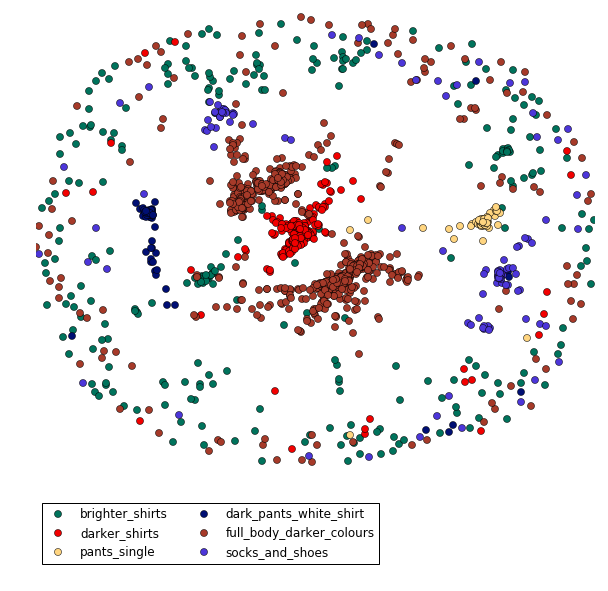

In [45]:
figure(figsize=(10,10))
axis('off')

coor = gl.SFrame({"x": [v[0] for v in pos.values()],
                  "y": [v[1] for v in pos.values()],
                  "c": [G.node[k]['category'] for k in pos.keys()]})

for cat, col in color_map.iteritems():
    si = coor[coor['c'] == cat]
    plot(si['x'], si['y'], color=col, marker='o', linestyle='', ms=7, label=cat)


legend(loc=0, numpoints=1, ncol=2)